https://www.pmorgan.com.au/tutorials/crostons-method/

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.handlers import scope
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic
from statsforecast.utils import ConformalIntervals

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

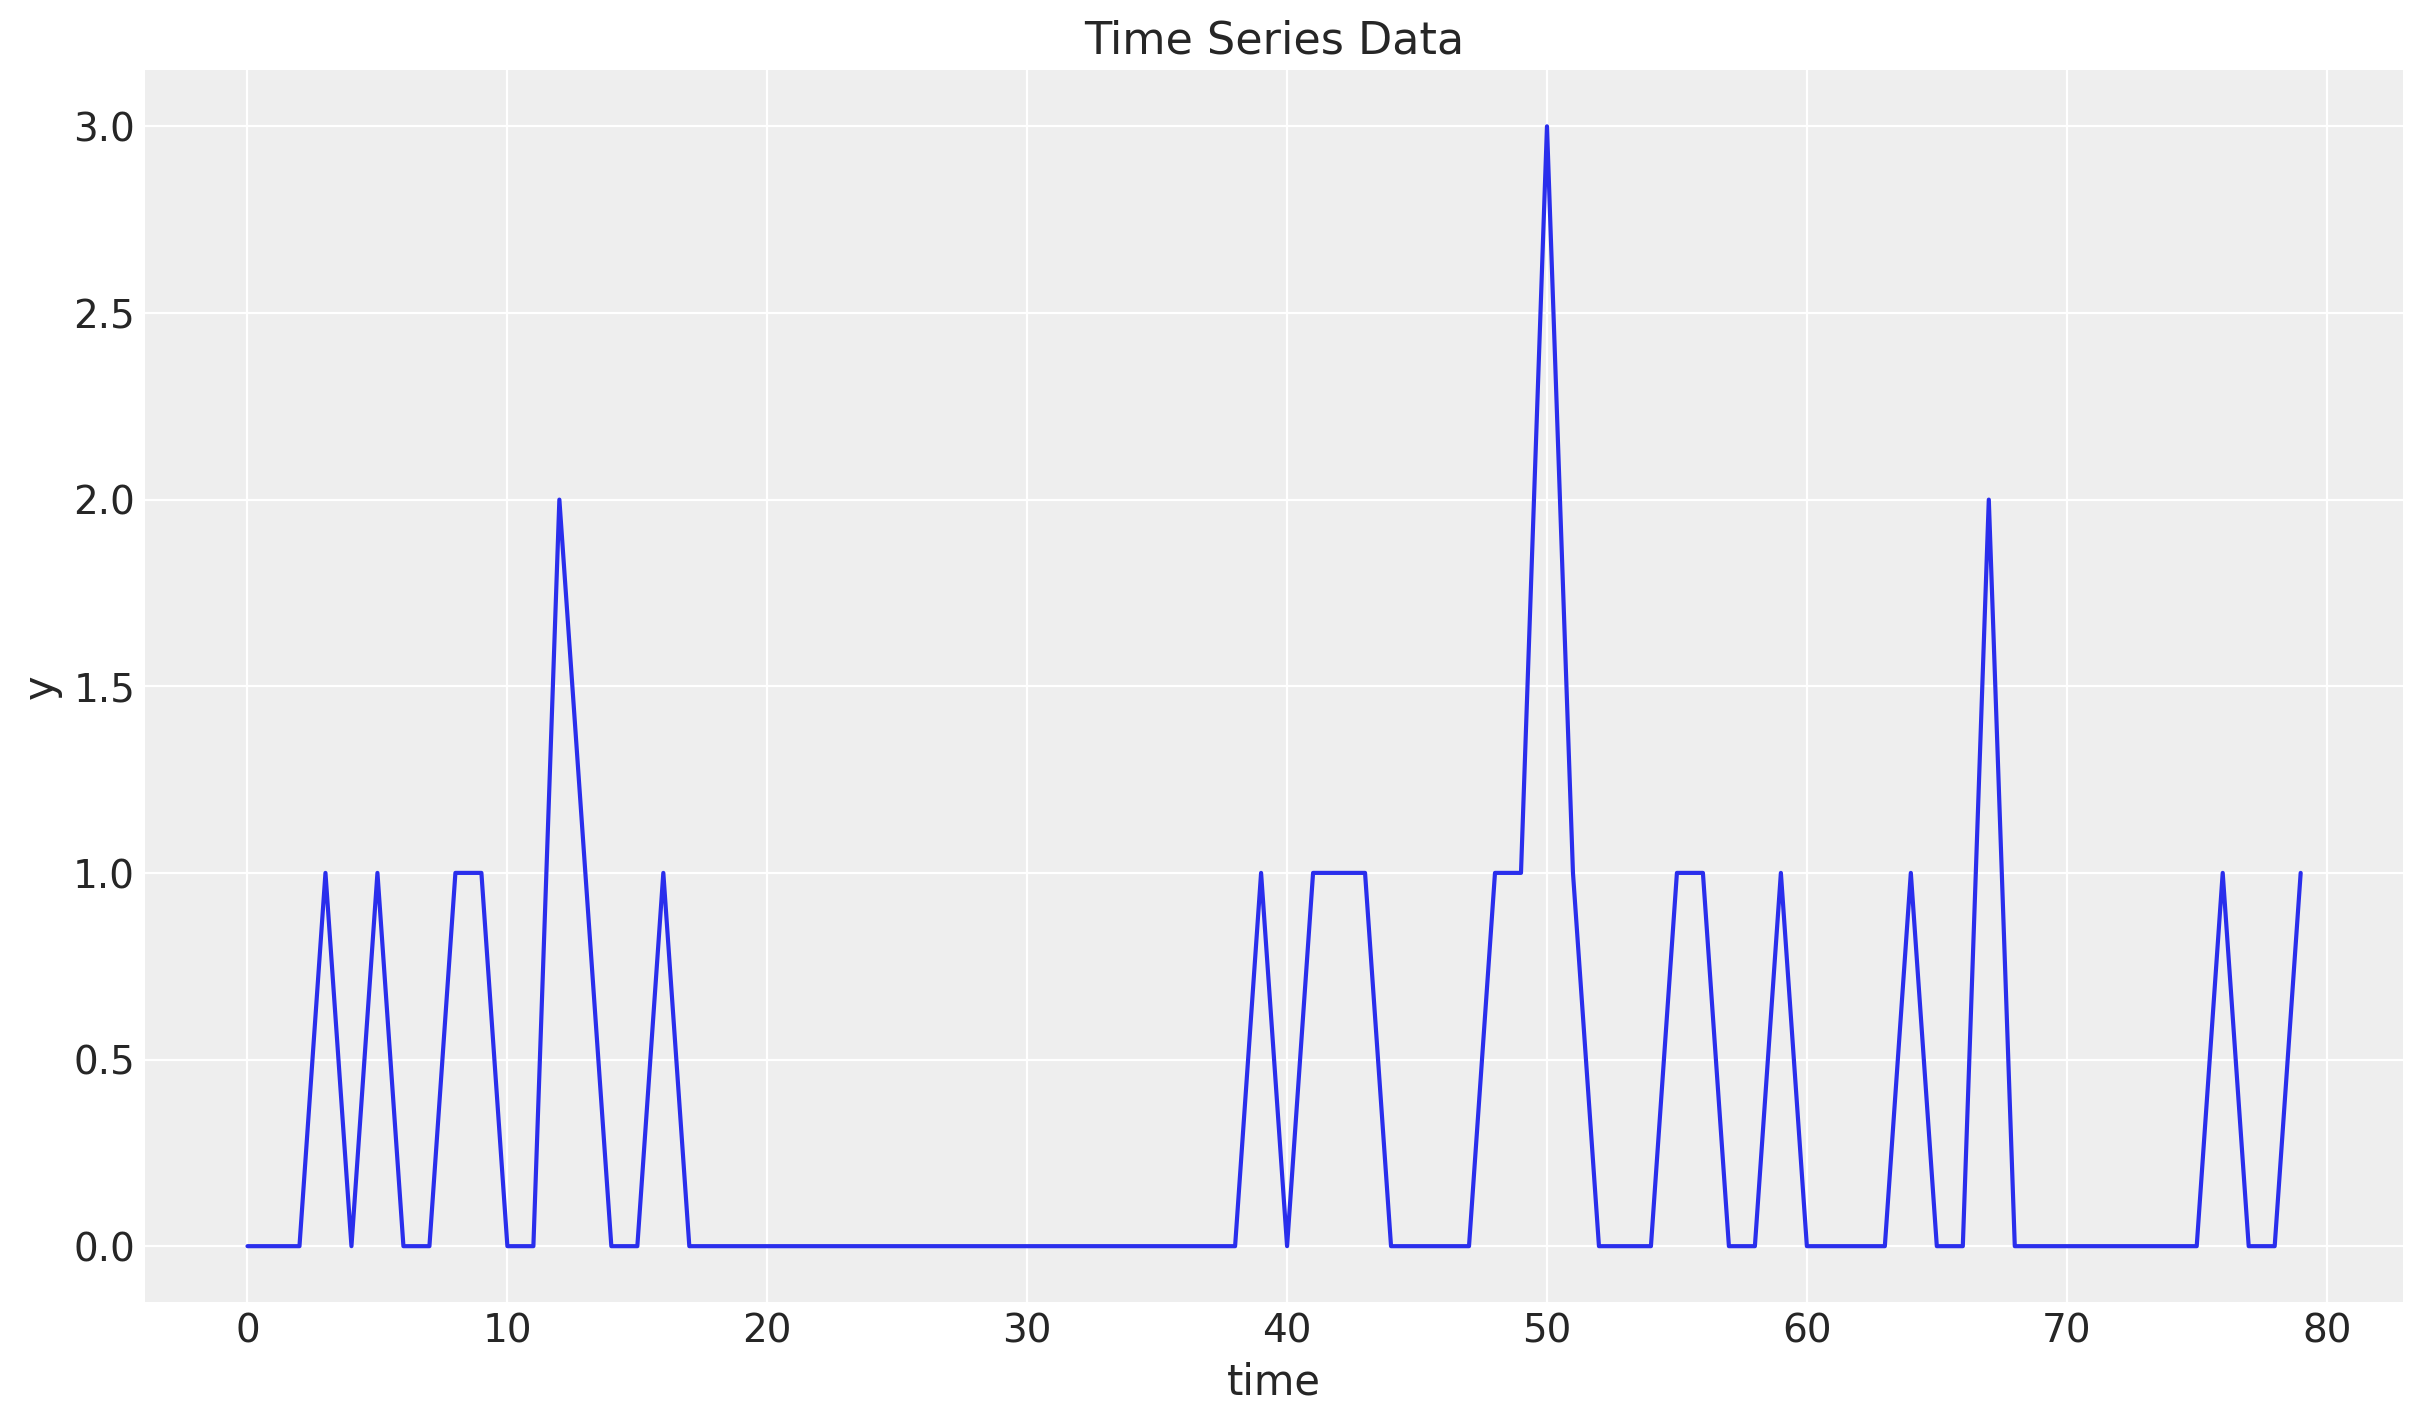

In [2]:
n = 80
lam = 0.3

y = random.poisson(key=rng_key, lam=lam, shape=(n,)).astype(jnp.float32)
t = jnp.arange(y.size)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

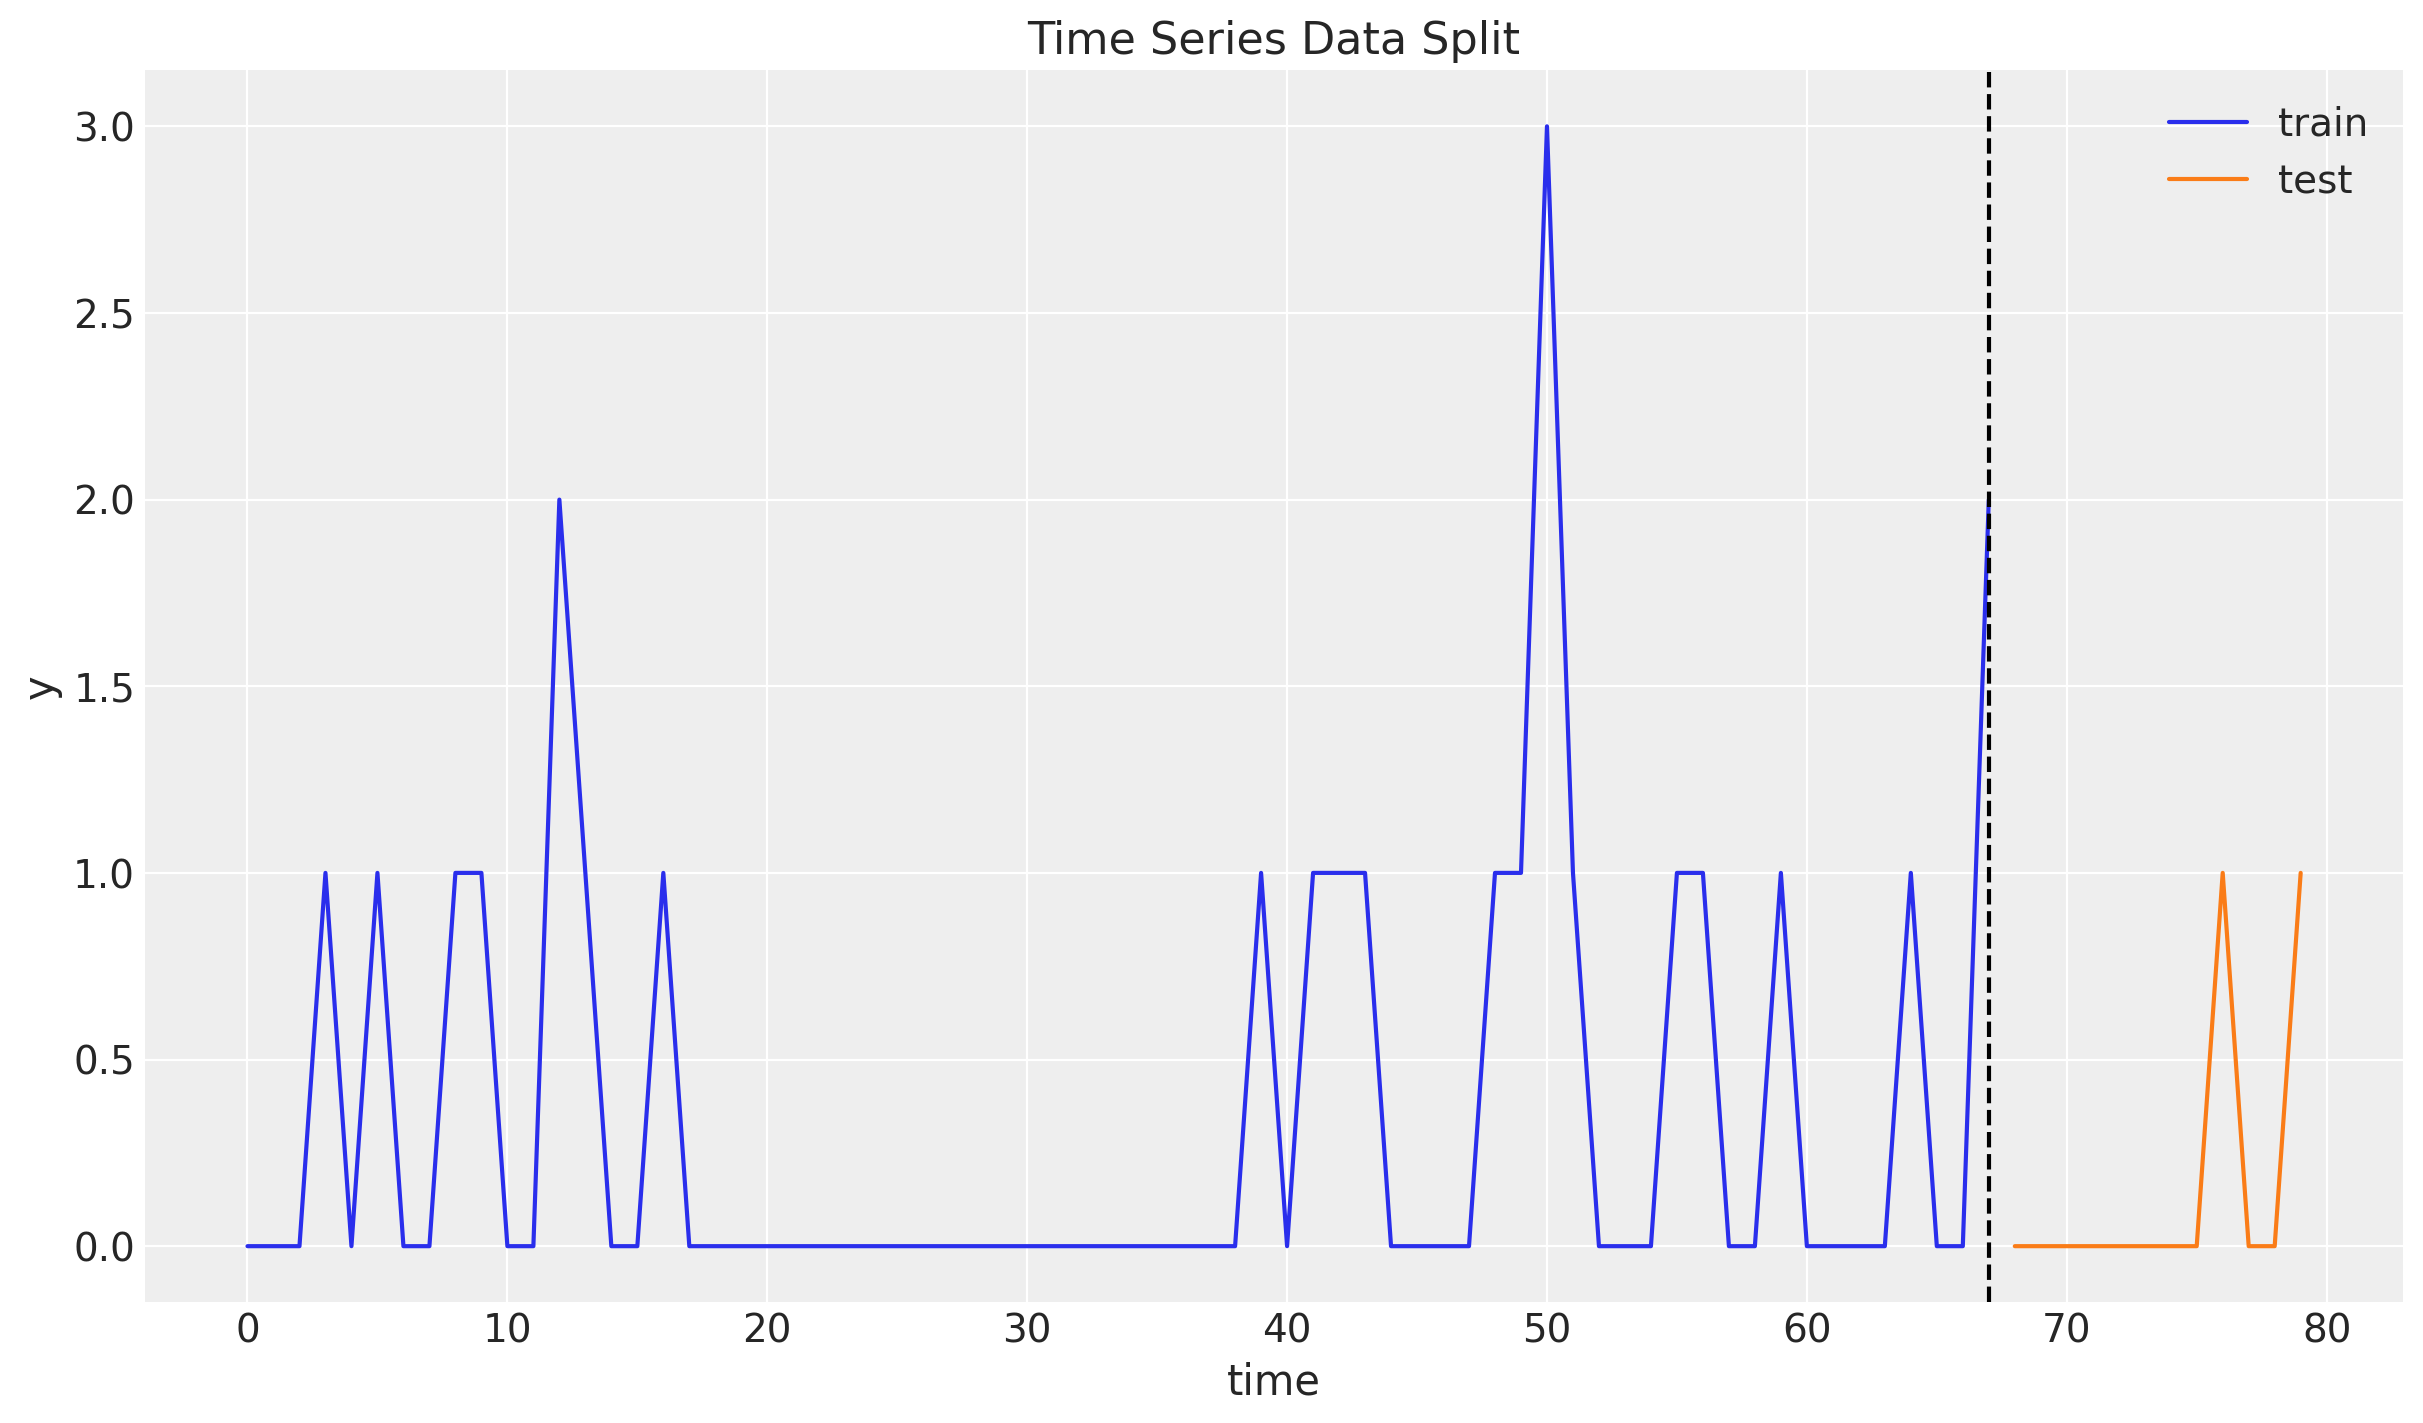

In [3]:
n = y.size

prop_train = 0.85
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

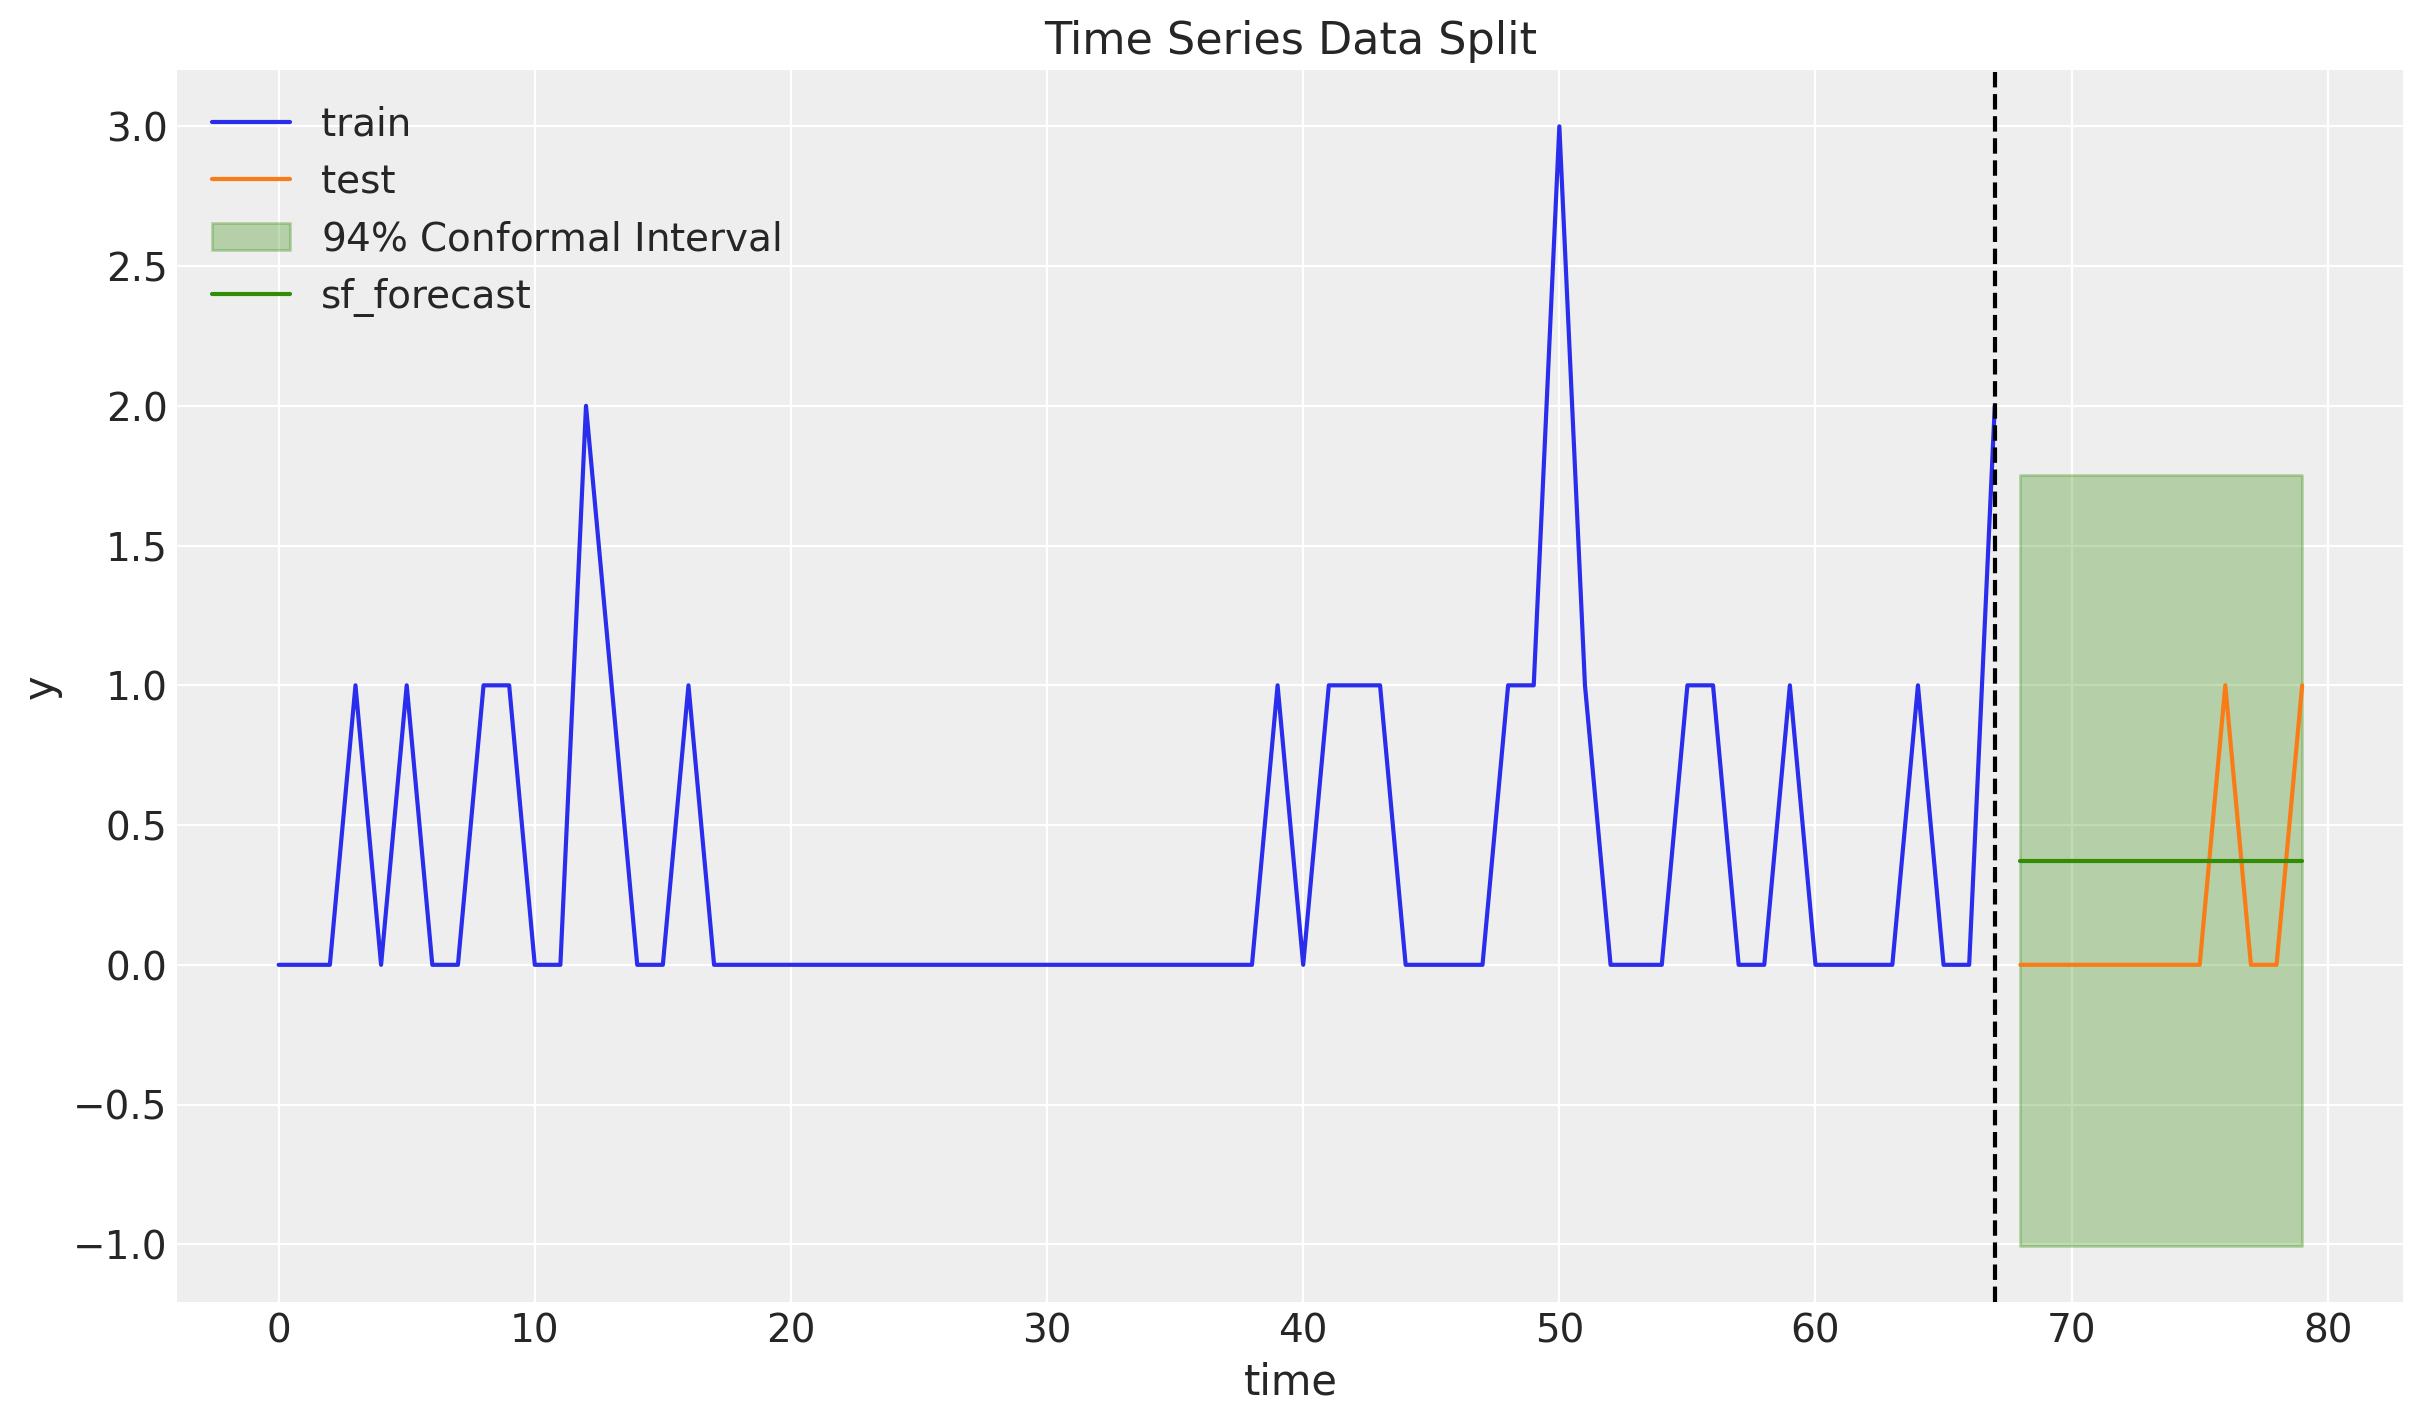

In [4]:
sf = StatsForecast(
    models=[CrostonClassic()],
    freq=1,
    n_jobs=-1,
)

train_df = pd.DataFrame({"unique_id": "a", "ds": t_train, "y": y_train})
test_df = pd.DataFrame({"unique_id": "a", "ds": t_test})

sf_forecast = sf.forecast(
    h=y_test.size,
    df=train_df,
    level=[94],
    prediction_intervals=ConformalIntervals(n_windows=5),
)


fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.fill_between(
    t_test,
    sf_forecast["CrostonClassic-lo-94"],
    sf_forecast["CrostonClassic-hi-94"],
    color="C2",
    alpha=0.3,
    label=f"$94\%$ Conformal Interval",
)
ax.plot(t_test, sf_forecast["CrostonClassic"], color="C2", label="sf_forecast")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

In [5]:
z = y_train[y_train != 0]

print(f"Demand: {z}")

Demand: [1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 2.]


In [6]:
p_idx = jnp.flatnonzero(y_train).astype(jnp.float32)
p = jnp.diff(p_idx, prepend=-1)

print("Index: ", p_idx)
print("Period, p: ", p)

Index:  [ 3.  5.  8.  9. 12. 13. 16. 39. 41. 42. 43. 48. 49. 50. 51. 55. 56. 59.
 64. 67.]
Period, p:  [ 4.  2.  3.  1.  3.  1.  3. 23.  2.  1.  1.  5.  1.  1.  1.  4.  1.  3.
  5.  3.]


In [7]:
eps = jnp.finfo(float).eps

p_inv = 1 / (p + eps)

Text(0.5, 1.0, 'Period')

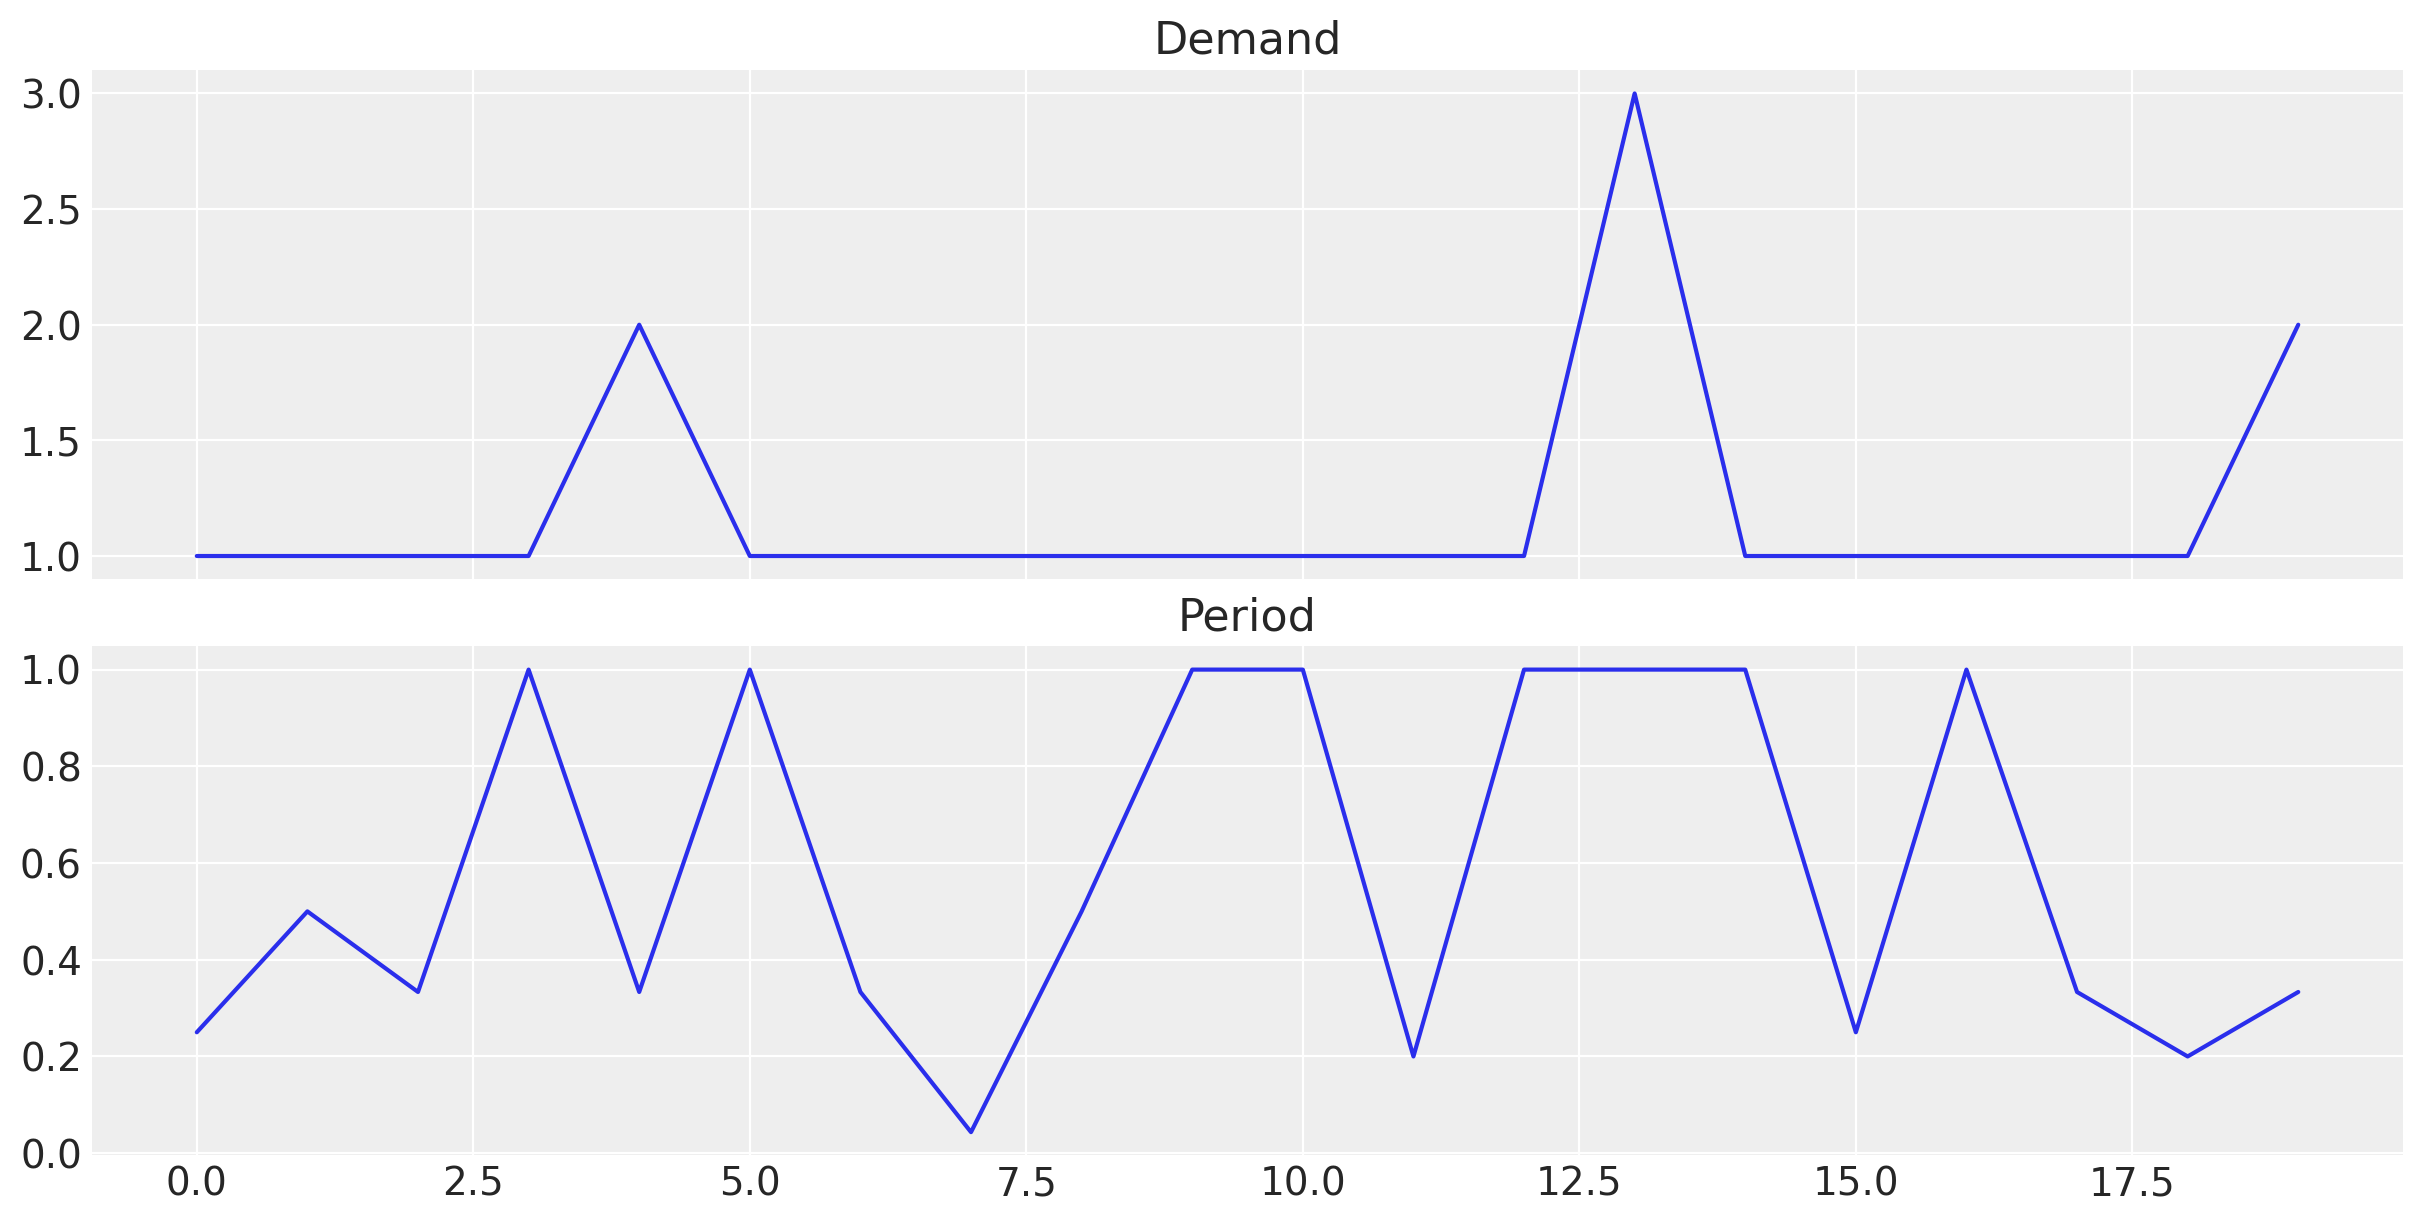

In [8]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 6), sharex=True, sharey=False, layout="constrained"
)
ax[0].plot(z)
ax[0].set_title("Demand")
ax[1].plot(p_inv)
ax[1].set_title("Period")

<Axes: >

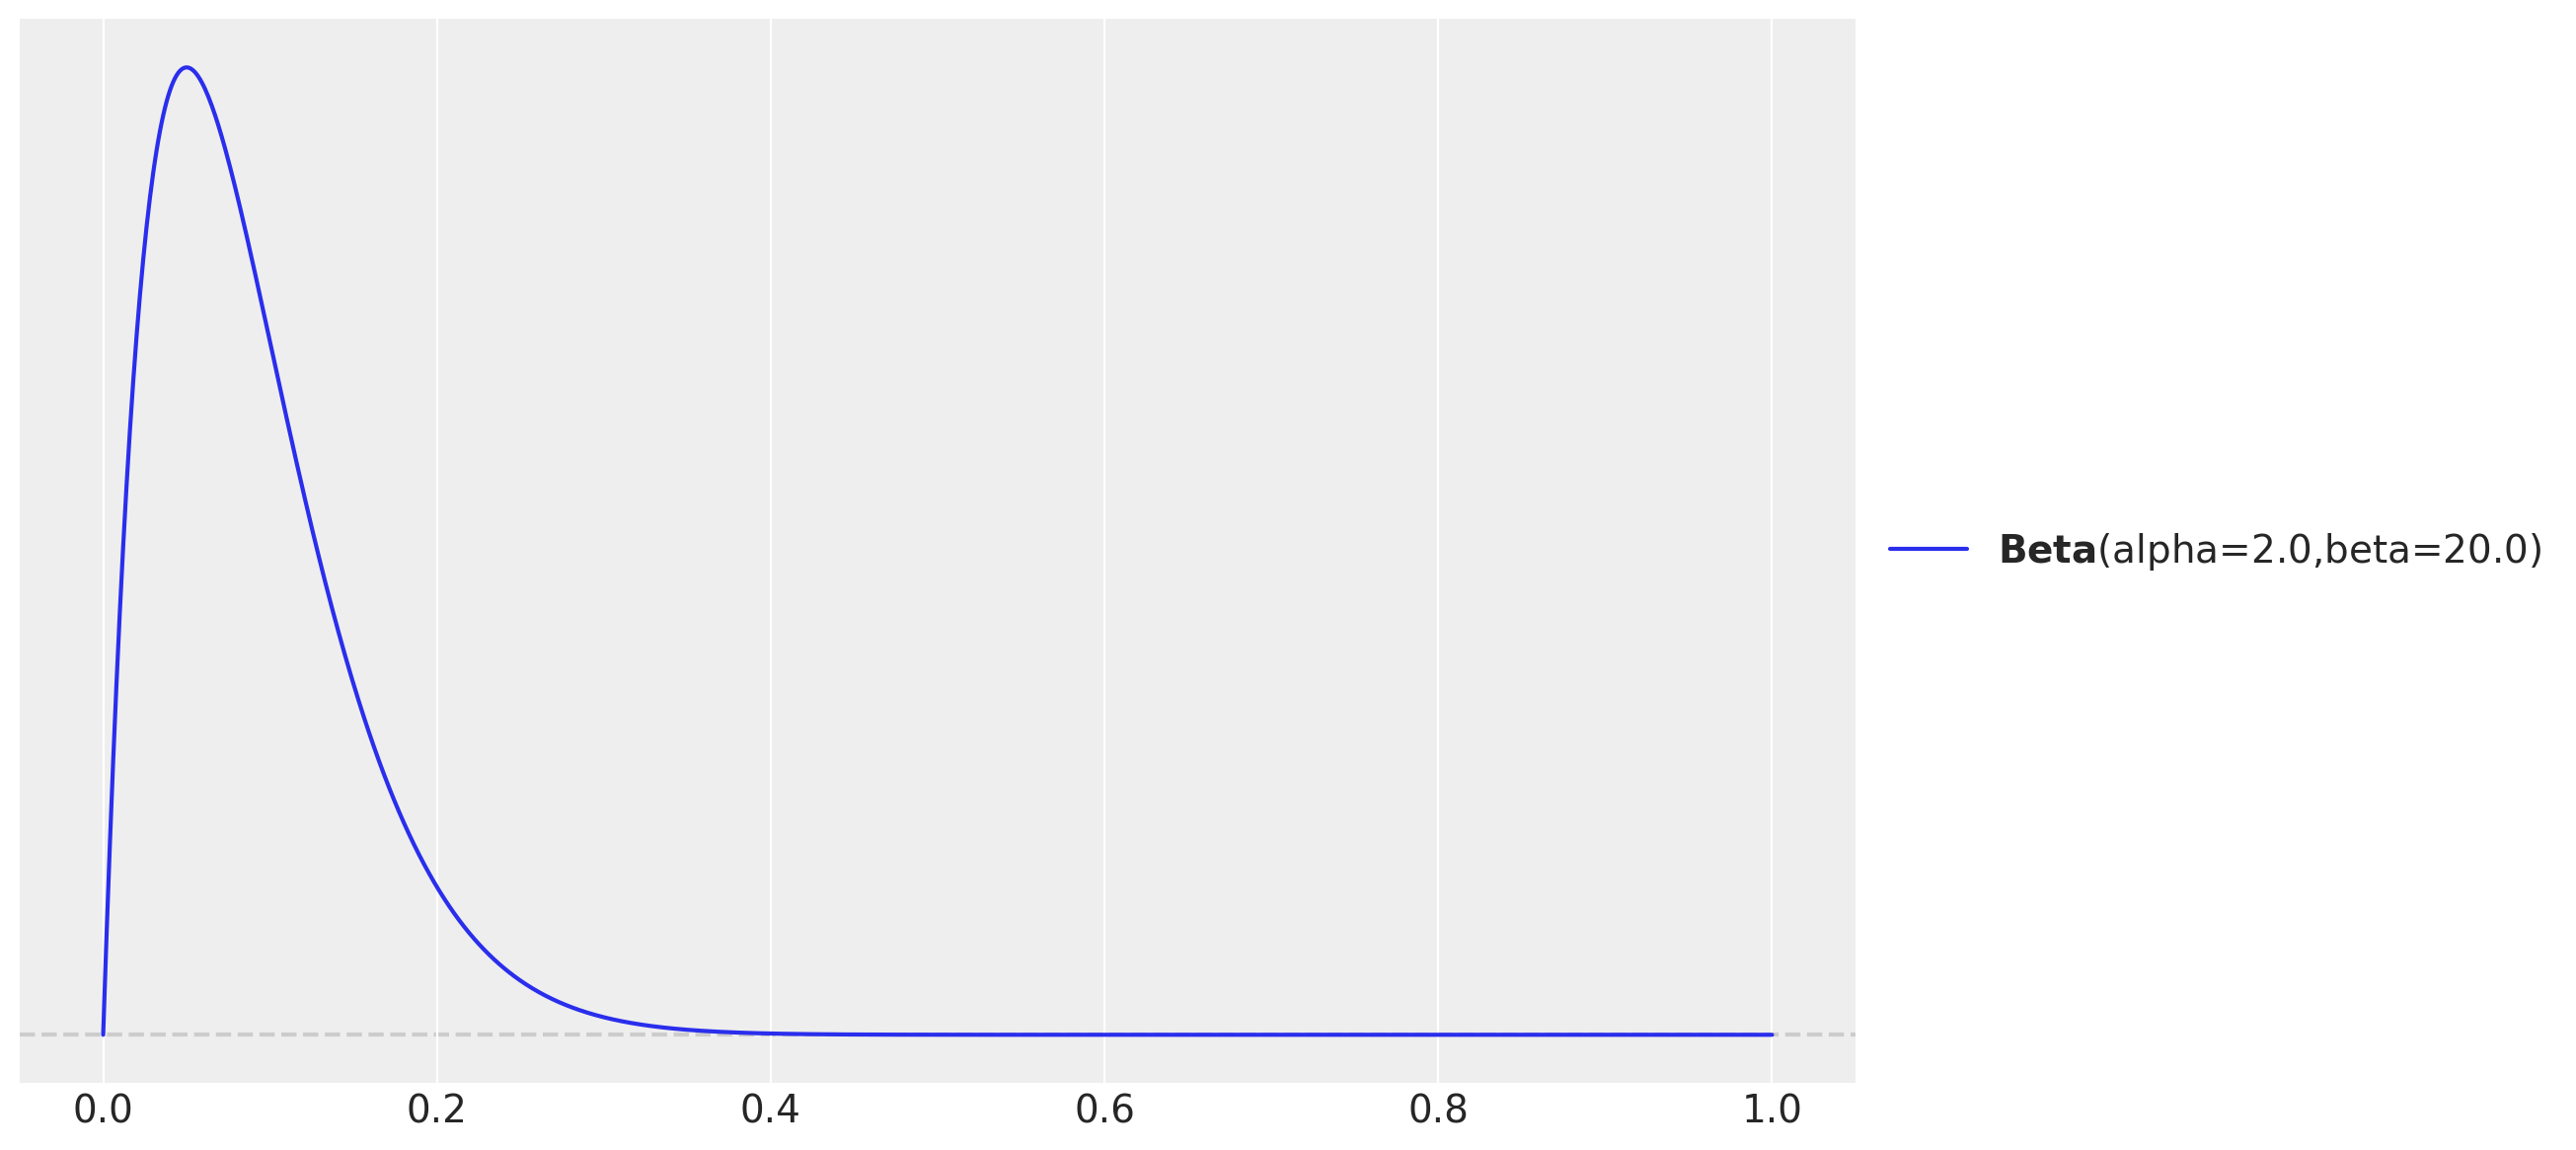

In [60]:
import preliz as pz

pz.Beta(2, 20).plot_pdf()

In [61]:
def level_model(ts: ArrayImpl, future: int = 0) -> None:
    t_max = ts.size

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample(
        "level_smoothing", dist.Beta(concentration1=2, concentration0=20)
    )
    level_init = numpyro.sample("level_init", dist.Normal(loc=0, scale=1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(scale=1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * y[t] + (1 - level_smoothing) * previous_level,
            previous_level,
        )

        mu = previous_level
        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise))

        return level, pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": ts}):
        _, preds = scan(
            transition_fn,
            level_init,
            jnp.arange(t_max + future),
        )

    # --- Forecast ---

    if future > 0:
        return numpyro.deterministic("ts_forecast", preds[-future:])

In [62]:
def croston_model(z: ArrayImpl, p_inv: ArrayImpl, future: int = 0) -> None:
    z_forecast = scope(level_model, "demand")(z, future)
    p_inv_forecast = scope(level_model, "period_inv")(p_inv, future)

    if future > 0:
        numpyro.deterministic("z_forecast", z_forecast)
        numpyro.deterministic("p_inv_forecast", p_inv_forecast)
        numpyro.deterministic("forecast", z_forecast * p_inv_forecast)

In [63]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [64]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(rng_subkey, croston_model, inference_params, z, p_inv)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [65]:
idata = az.from_numpyro(posterior=mcmc)

az.summary(data=idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
demand/level_init,1.341,0.195,1.013,1.745,0.002,0.002,6805.0,4966.0,1.0
demand/level_smoothing,0.030,0.021,0.000,0.066,0.000,0.000,7125.0,4897.0,1.0
demand/noise,0.594,0.109,0.414,0.800,0.001,0.001,8332.0,5035.0,1.0
period_inv/level_init,0.643,0.164,0.344,0.973,0.002,0.001,6897.0,4839.0,1.0
period_inv/level_smoothing,0.084,0.056,0.003,0.189,0.001,0.000,6147.0,3752.0,1.0
period_inv/noise,0.400,0.071,0.278,0.528,0.001,0.001,8498.0,5061.0,1.0


In [66]:
print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'Croston Model Trace')

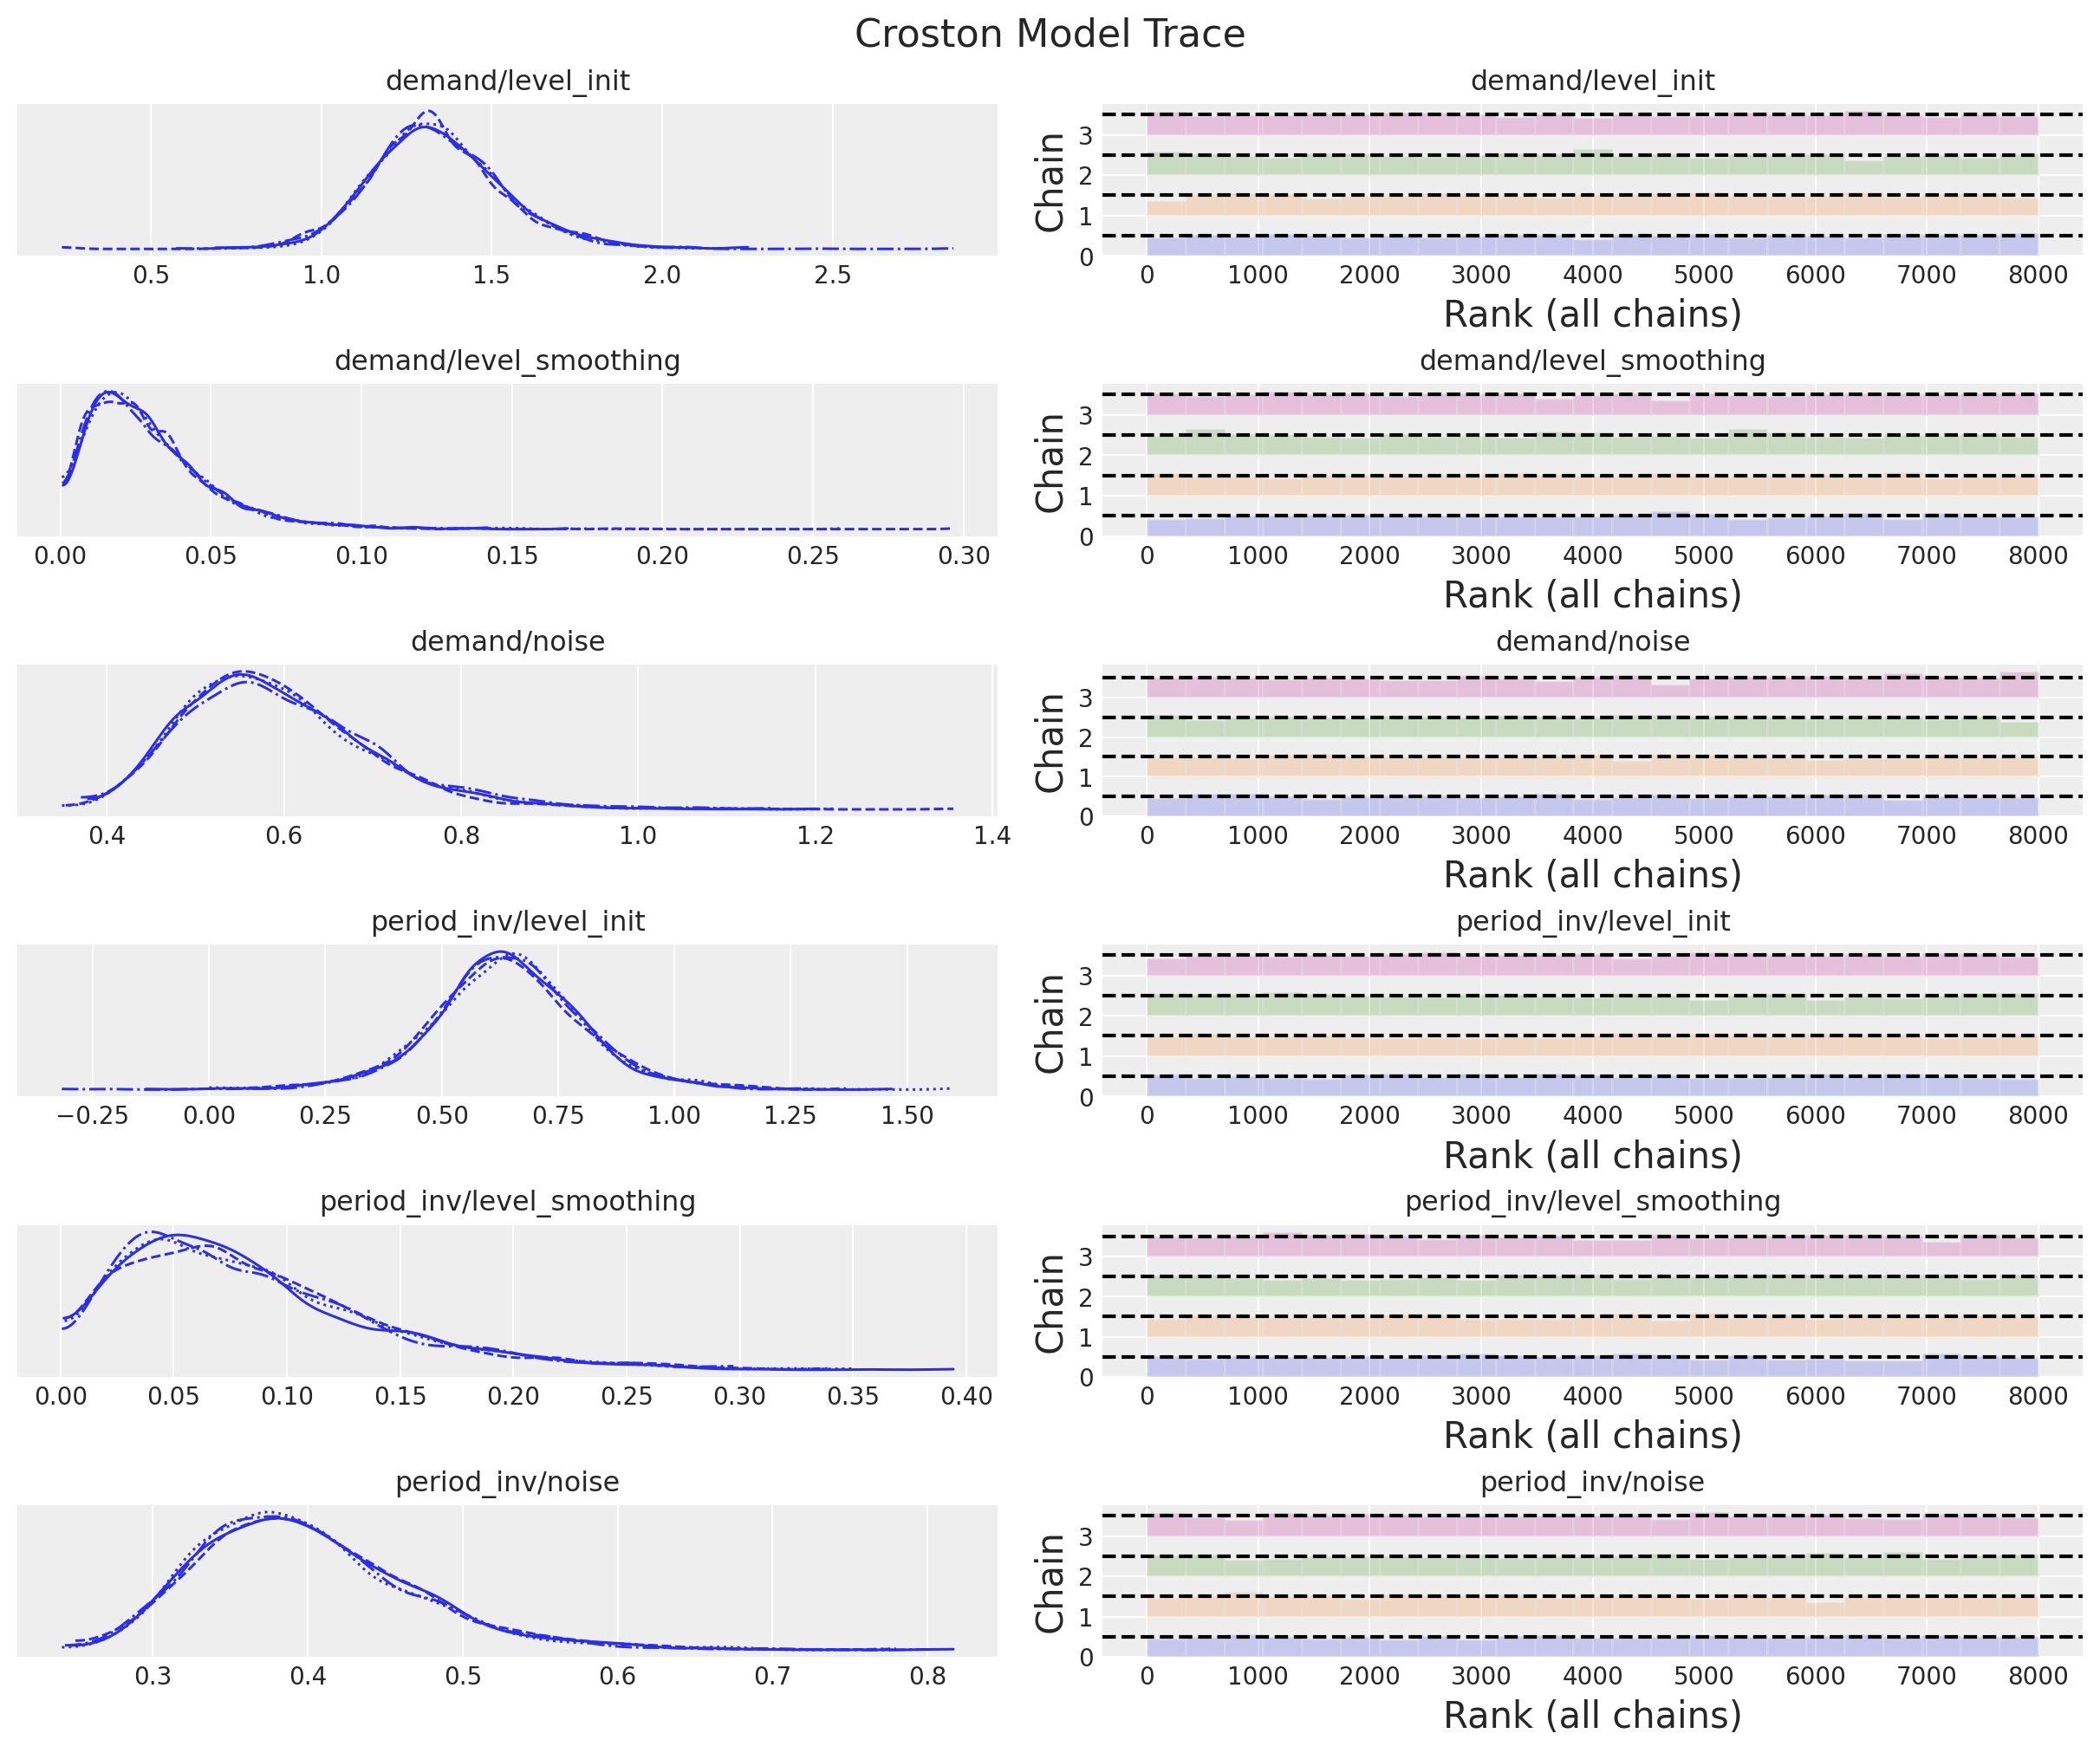

In [67]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Croston Model Trace", fontsize=16)

In [68]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["z_forecast", "p_inv_forecast", "forecast"],
    )
    return predictive(rng_key, *model_args)

In [69]:
rng_key, rng_subkey = random.split(key=rng_key)
croston_forecast = forecast(
    rng_subkey, croston_model, mcmc.get_samples(), z, p_inv, y_test.size
)

In [70]:
posterior_predictive = az.from_numpyro(
    posterior_predictive=croston_forecast,
    coords={"t": t_test},
    dims={"z_forecast": ["t"], "p_inv_forecast": ["t"], "forecast": ["t"]},
)

Text(0.5, 1.0, 'Period')

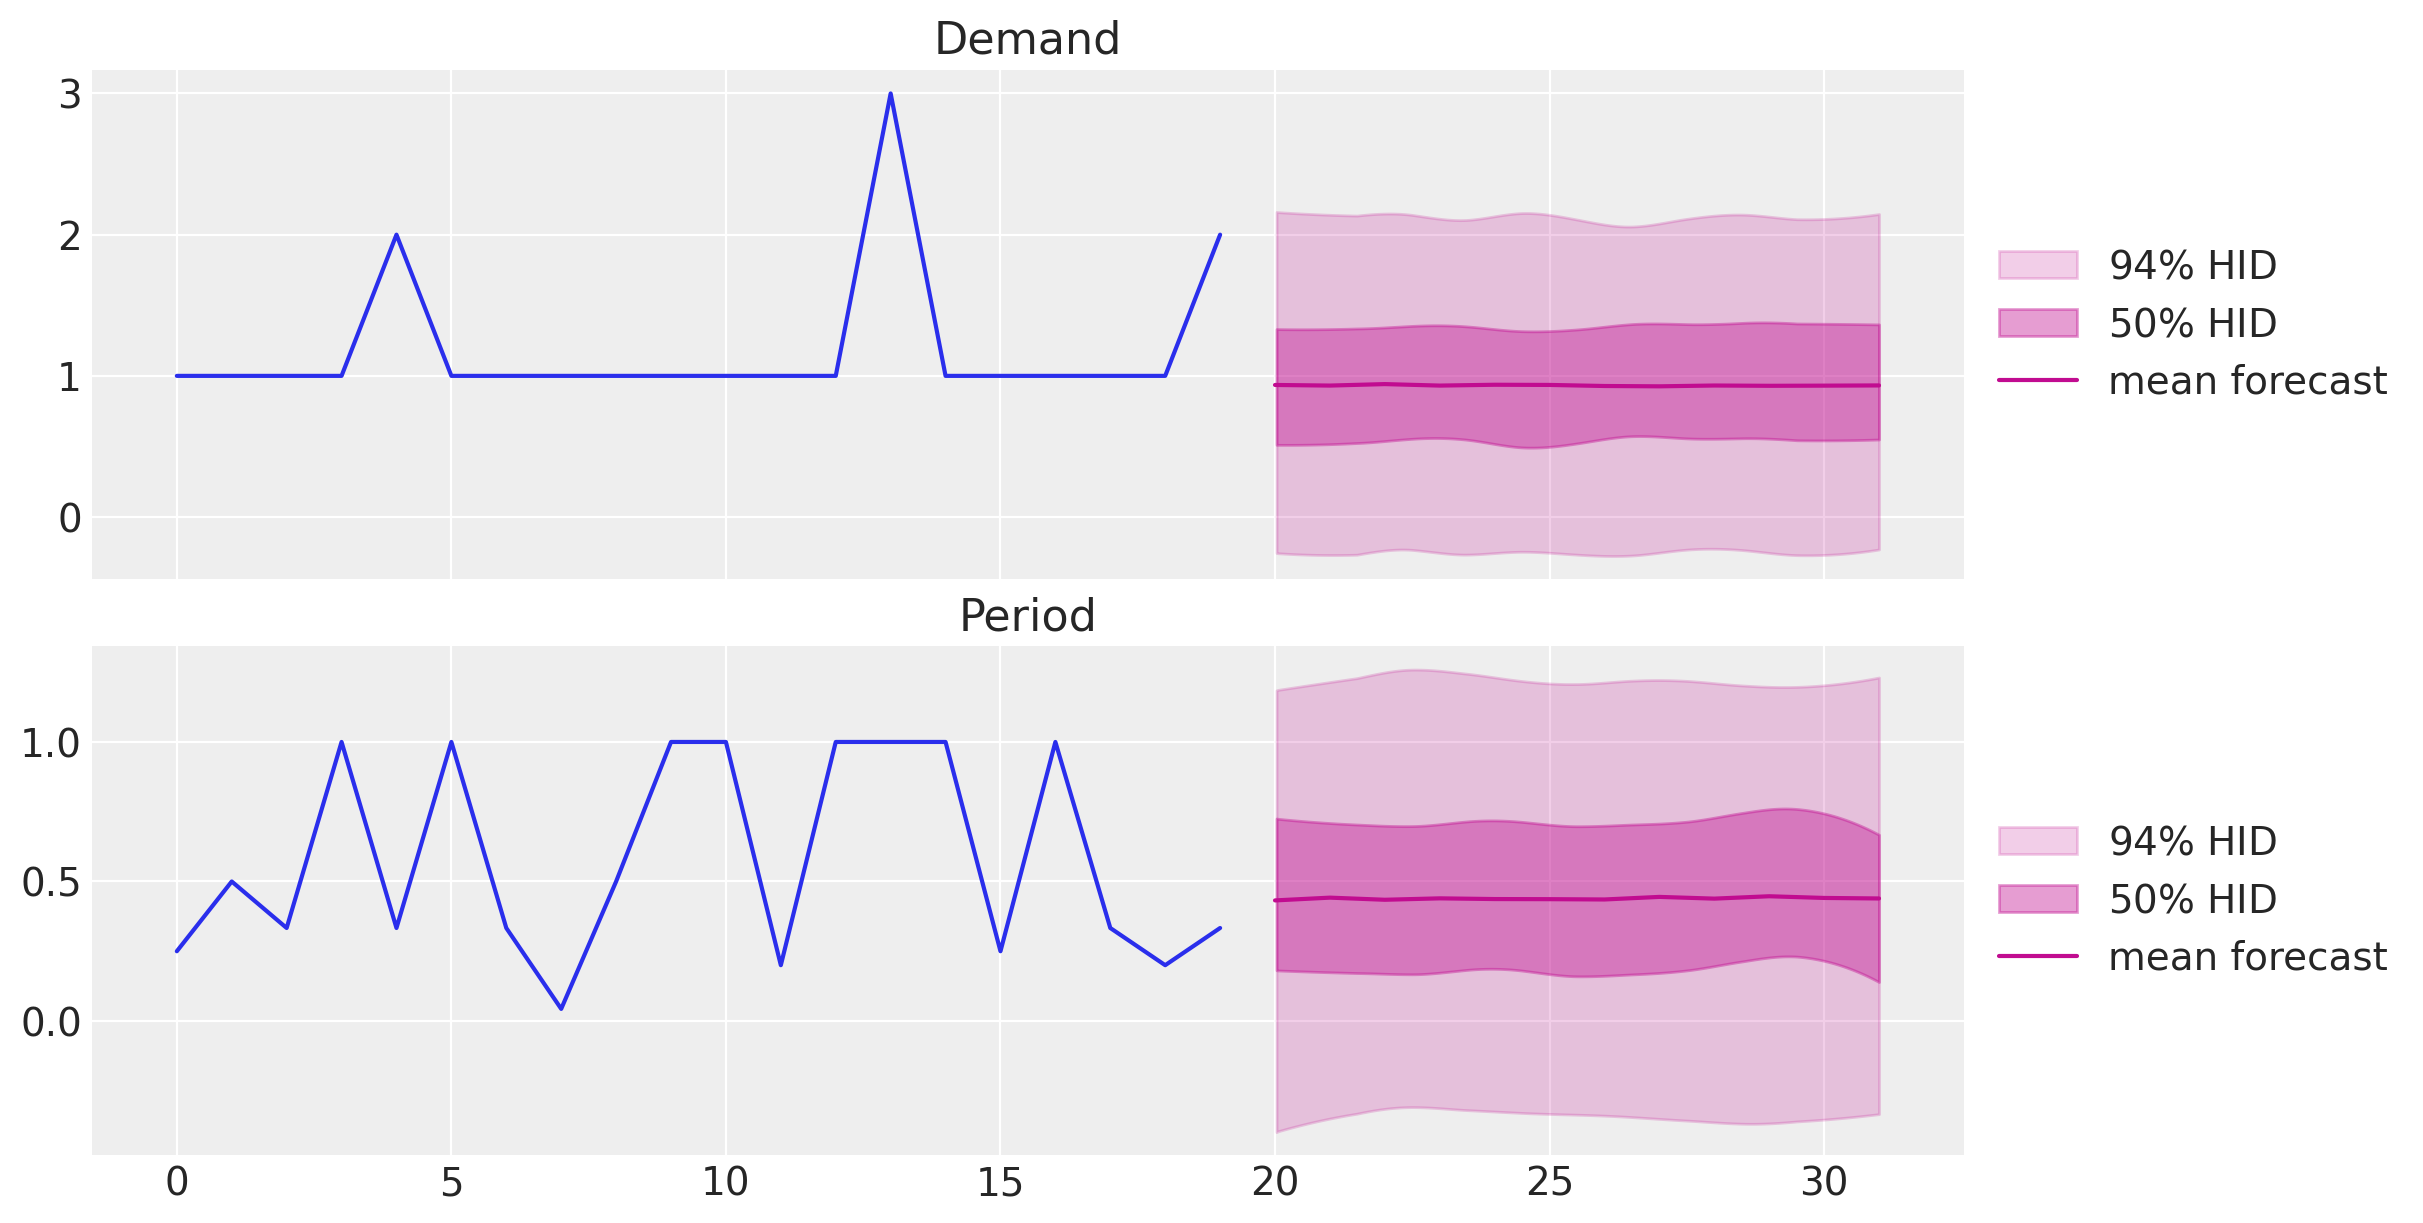

In [71]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 6), sharex=True, sharey=False, layout="constrained"
)
ax[0].plot(z)
az.plot_hdi(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["z_forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HID"},
    ax=ax[0],
)
az.plot_hdi(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["z_forecast"],
    hdi_prob=0.5,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": r"$50\%$ HID"},
    ax=ax[0],
)
ax[0].plot(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["z_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set_title("Demand")

ax[1].plot(1 / p)
az.plot_hdi(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["p_inv_forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HID"},
    ax=ax[1],
)
az.plot_hdi(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["p_inv_forecast"],
    hdi_prob=0.5,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": r"$50\%$ HID"},
    ax=ax[1],
)
ax[1].plot(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["p_inv_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set_title("Period")

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Level Model Forecast')]

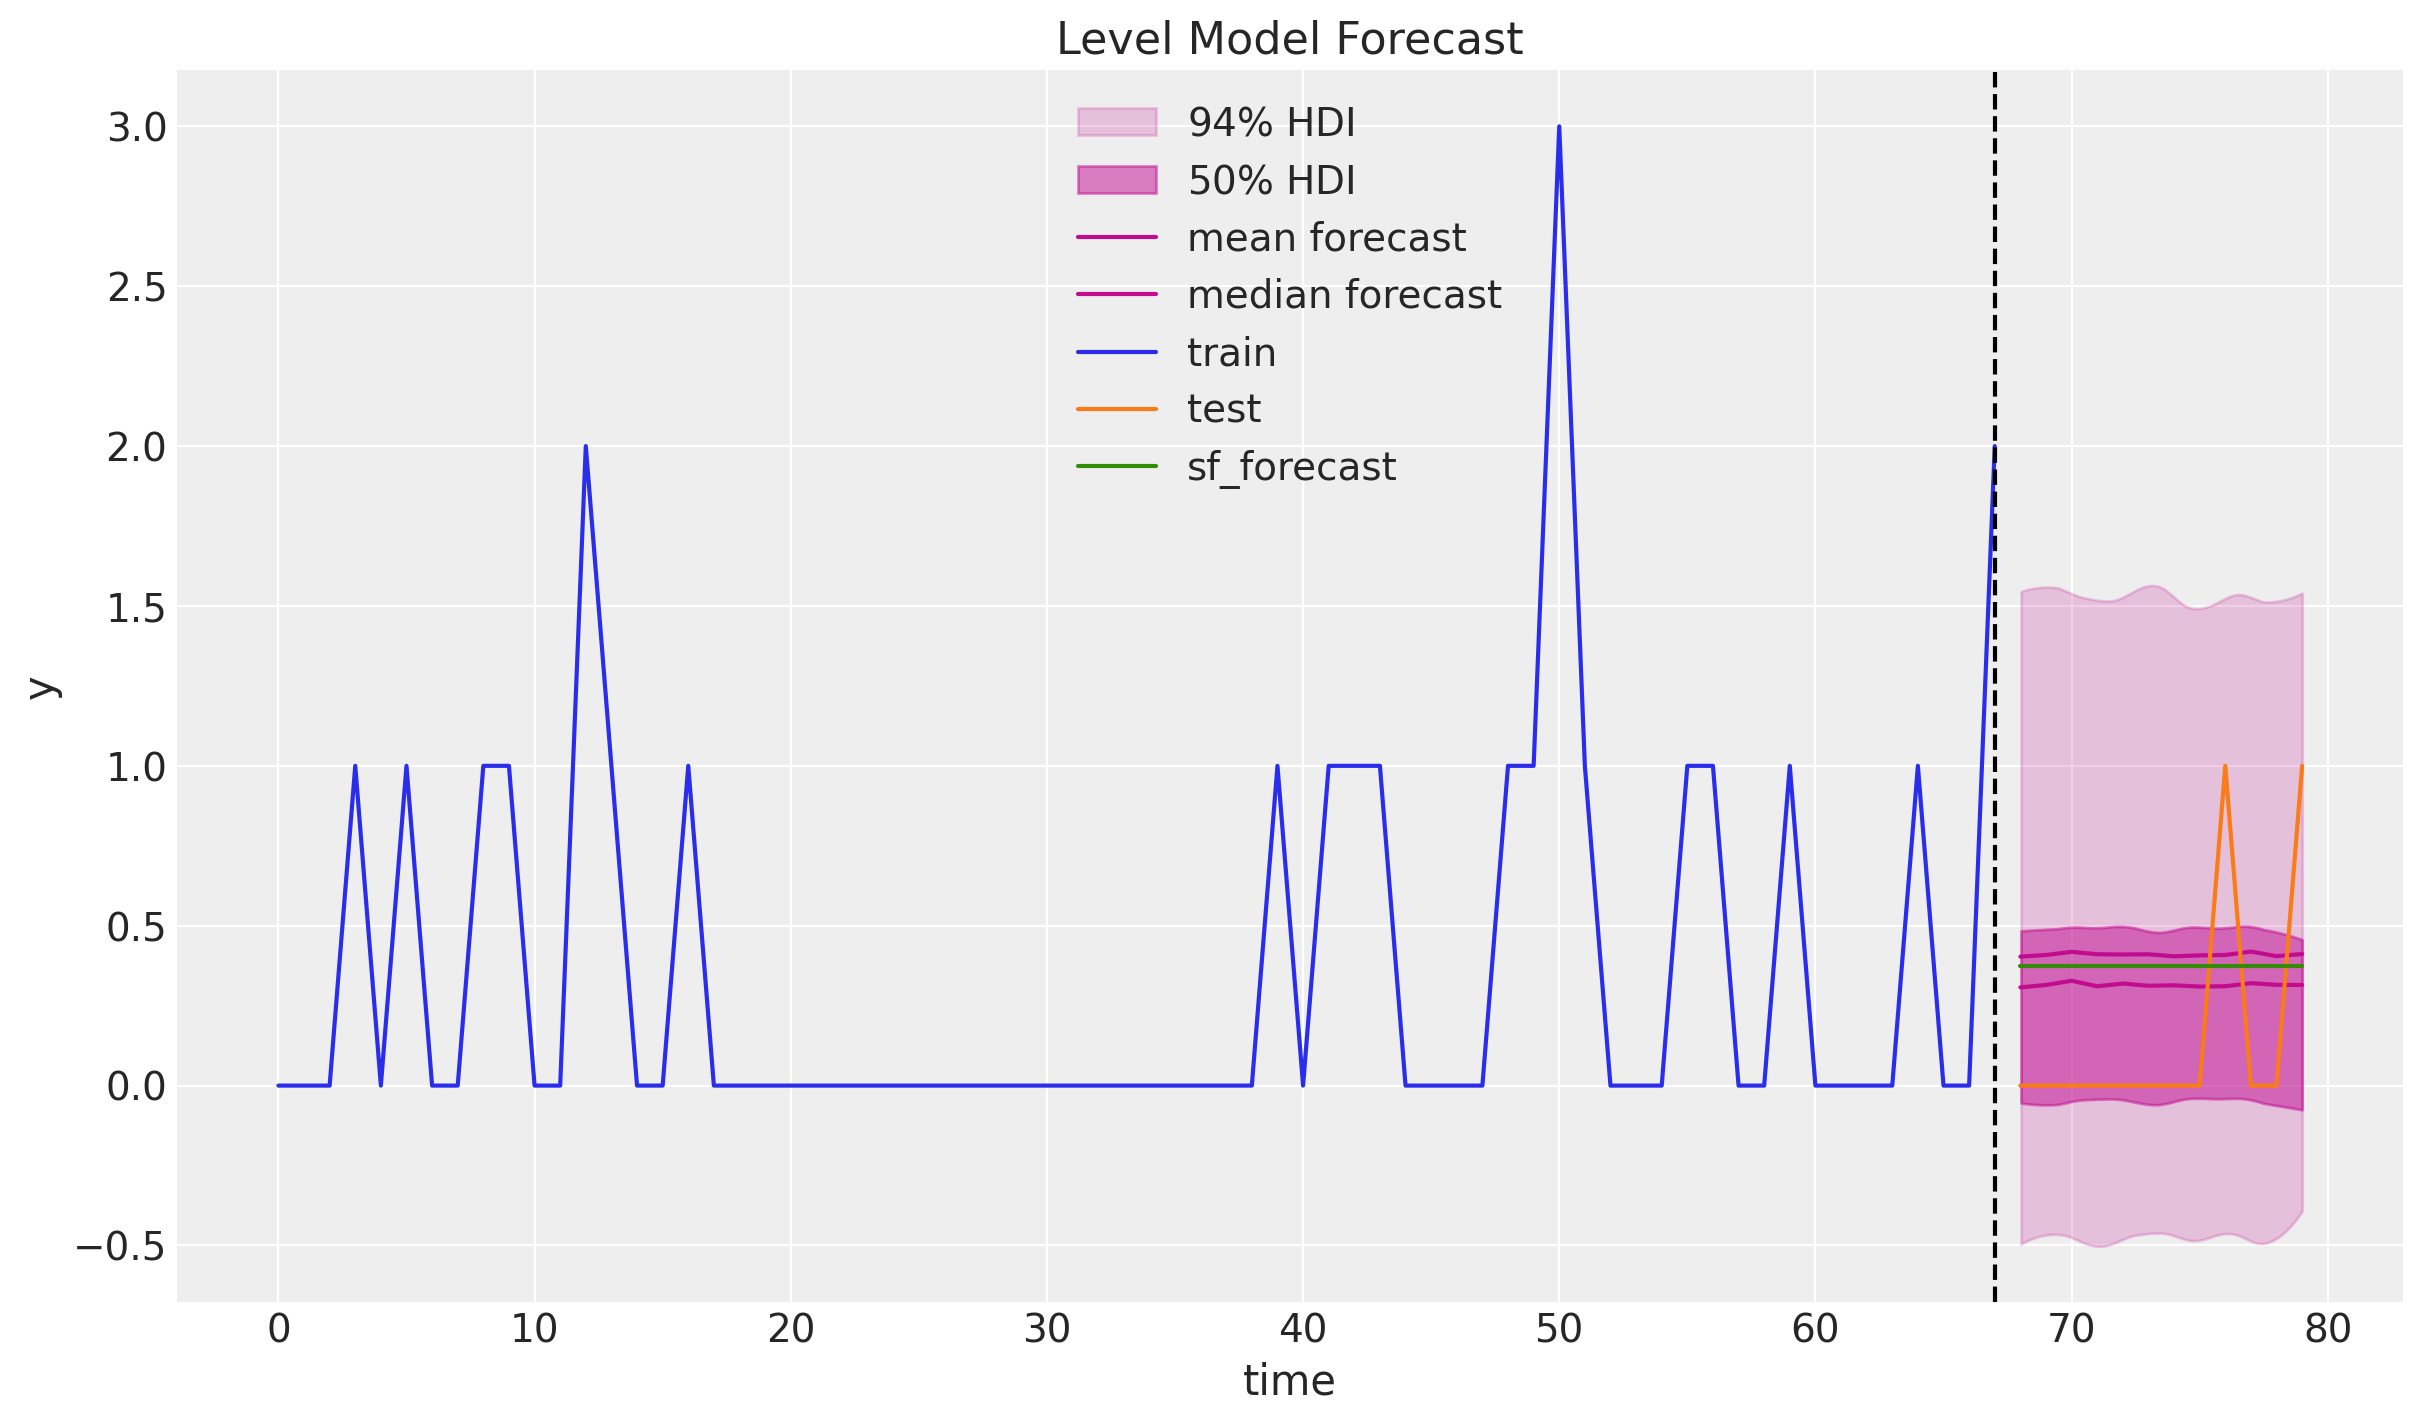

In [72]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["forecast"],
    hdi_prob=0.50,
    color="C3",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["forecast"].median(
        dim=("chain", "draw")
    ),
    color="C3",
    label="median forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.plot(t_test, sf_forecast["CrostonClassic"], color="C2", label="sf_forecast")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level Model Forecast")